---
title: 'Hierarchical Regression With Missing Data'
date: 2024-09-10
author: 'Gabriel Stechschulte'
draft: false
math: true
categories: ['probabilistic-programming']
---

<!--eofm-->

Hierarchical regression, also known as multilevel modeling, is a powerful statistical technique that allows us to analyze data with a nested structure. This approach is particularly useful when dealing with data that has natural groupings, such as students within schools, patients within hospitals, or in our case, product configurations within manufacturing processes. One of the key advantages of hierarchical regression is its ability to effectively handle missing data in groups, making it an invaluable tool for real-world applications where data incompleteness is often the norm rather than the exception.

## Benefits in Real-World Use Cases

In many real-world scenarios, hierarchical regression offers several benefits:

1. **Handling Unbalanced Data**. It can effectively deal with situations where some groups have more observations than others.

2. **Partial Pooling**. It strikes a balance between completely pooled and unpooled analyses, allowing information to be shared across groups while still accounting for group-specific variations.

3. **Missing Data**. It can handle missing data at various levels of the hierarchy without requiring complete case analysis or imputation.

4. **Improved Estimation**. By borrowing strength across groups, it can provide more accurate and stable estimates, especially for groups with limited data.

5. **Flexibility**. It allows for the inclusion of both group-level and individual-level predictors, enabling a more comprehensive analysis.

## Simulated Example: Manufacturing Process Analysis

To illustrate the power of hierarchical regression in handling missing data, let's consider a simulated example from a manufacturing context. We'll analyze how different machine process parameters affect production speed across two product groups.

In this simulation, we generate data for two product groups with different dependencies on machine process parameters:

- Product Group 1 depends on feed speed and pull acceleration.
- Product Group 2 depends on feed speed, pull acceleration, and cutting wait time.

Crucially, the cutting wait time for Product Group 1 is set to NaN, simulating a scenario where this parameter is not applicable or not measured for this group.

In [219]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import numpyro.distributions as dist

from jax import random
from numpyro.infer import Predictive

In [54]:
n_samples = 500

# Generate machine process parameters for both groups
feed_speed = np.random.uniform(1, 10, n_samples)
pull_acceleration = np.random.uniform(0.5, 5, n_samples)
cutting_wait_time = np.random.uniform(0.1, 2, n_samples)

# Create product groups
product_group = np.array(['Product_Group_1'] * (n_samples // 2) + ['Product_Group_2'] * (n_samples // 2))

# Calculate production speed
production_speed = np.zeros(n_samples)

# Product Group 1: depends on feed speed and pull acceleration (Cutting Wait Time is NaN)
mask_pg1 = product_group == 'Product_Group_1'

# Increased coefficients for Product Group 1 to ensure higher production speed
production_speed[mask_pg1] = (feed_speed[mask_pg1] * 2.5 + 
                              pull_acceleration[mask_pg1] * 3 + 
                              np.random.normal(0, 0.5, sum(mask_pg1)))

# Product Group 2: depends on all three parameters
mask_pg2 = product_group == 'Product_Group_2'
production_speed[mask_pg2] = (feed_speed[mask_pg2] * 1 + 
                              pull_acceleration[mask_pg2] * 0.5 + 
                              cutting_wait_time[mask_pg2] * 3 + 
                              np.random.normal(0, 0.5, sum(mask_pg2)))

# Create DataFrame with NaN for Cutting Wait Time in Product Group 1
simulated_dataset = pd.DataFrame({
    'Product_Group': product_group,
    'Feed_Speed': feed_speed,
    'Pull_Acceleration': pull_acceleration,
    'Cutting_Wait_Time': [np.nan if x == 'Product_Group_1' else cutting_wait_time[i] for i,x in enumerate(product_group)],
    'Production_Speed': production_speed
})

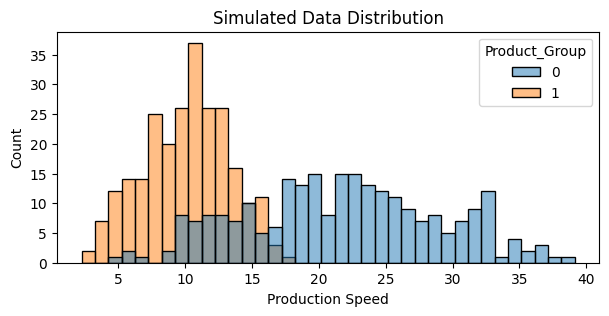

In [256]:
plt.figure(figsize=(7, 3))
sns.histplot(
    data=simulated_dataset, 
    x="Production_Speed", 
    hue="Product_Group",
    binwidth=1
)
plt.xlabel("Production Speed")
plt.title("Simulated Data Distribution");

In [254]:
# sns.pairplot(simulated_dataset.iloc[:, 0:], hue="Product_Group", corner=True);

In [57]:
simulated_dataset["Product_Group"] = (simulated_dataset["Product_Group"]
                                      .map({
                                          "Product_Group_1": 0, 
                                          "Product_Group_2": 1
                                          })
                                    )

## Parameter Masking for Missing Data

To handle the missing data in our hierarchical model, we employ a technique called parameter masking. This approach allows us to effectively "turn off" certain parameters for specific groups where they are not applicable. Here's how it works in our model:

Key aspects of this approach:

1. We use an `indicators` tensor to specify which parameters are relevant for each product group.
2. The input data `X` is masked to replace NaNs with zeros, and then multiplied by the indicators.
3. The weights `w` are also masked using the indicators, ensuring that irrelevant parameters don't contribute to the predictions.

This approach allows the model to learn parameters even when data is missing for some groups, by effectively ignoring those parameters in the relevant calculations.

In [72]:
parameter_mask = jnp.array([
    [1, 1, 0],
    [1, 1, 1]
])
config_idx = jnp.array(simulated_dataset["Product_Group"].values)
X = jnp.array(simulated_dataset.iloc[:, 1:4].values)
y = jnp.array(simulated_dataset["Production_Speed"].values)

In [257]:
def model(indicators, config_idx, X, y=None):
    n_configs, n_params = indicators.shape

    # Create a masked version of X where NaNs are treated as zeros based on the indicators
    X_masked = jnp.where(jnp.isnan(X), 0.0, X) * indicators[config_idx]

    # Group-specific effects
    with numpyro.plate("config_i", n_configs):
        alpha = numpyro.sample("alpha", dist.Normal(0., 5.))
        with numpyro.plate("param_i", n_params):
            w = numpyro.sample("w", dist.Normal(0., 5.))

    # Compute the weighted sum of features using indicators to zero-out unused parameters
    w_masked = jnp.multiply(w.T, indicators)
    
    eq = alpha[config_idx] + jnp.sum(jnp.multiply(X_masked, w_masked[config_idx]), axis=-1)
    mu = numpyro.deterministic("mu", eq)
    scale = numpyro.sample("scale", dist.HalfNormal(5.))

    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mu, scale), obs=y)

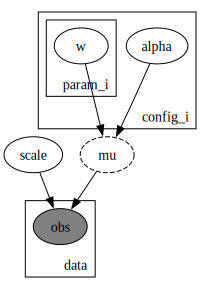

In [258]:
numpyro.render_model(
    model, 
    model_args=(
        parameter_mask,
        config_idx,
        X,
        y
    ),
    render_params=True
)

In [243]:
rng_key = random.PRNGKey(seed=42)
rng_key, rng_subkey = random.split(key=rng_key)

kernel = numpyro.infer.NUTS(model)

mcmc = numpyro.infer.MCMC(
    kernel, 
    num_warmup=200, 
    num_samples=300, 
    num_chains=4, 
    chain_method="vectorized"
)

mcmc.run(
    rng_subkey,
    parameter_mask,
    config_idx,
    X,
    y
)

sample: 100%|██████████| 500/500 [00:03<00:00, 148.27it/s]


## Model Inference and Results

After running MCMC inference on our model, we can examine the parameter estimates and make predictions.

In [244]:
# Parameter estimates for w[2, 0] are actually 0.0 once data is passed 
# through the program
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.03      0.11     -0.04     -0.20      0.15    598.37      1.00
  alpha[1]      0.05      0.12      0.05     -0.18      0.22    797.79      1.01
     scale      0.52      0.02      0.52      0.50      0.55   1058.94      1.00
    w[0,0]      2.51      0.01      2.51      2.49      2.53    837.47      1.00
    w[0,1]      1.00      0.01      1.00      0.98      1.02   1350.56      1.00
    w[1,0]      2.98      0.02      2.98      2.94      3.02    740.98      1.00
    w[1,1]      0.49      0.03      0.49      0.45      0.53   1002.80      1.00
    w[2,0]      0.11      5.30     -0.03     -7.42      9.98    893.63      1.00
    w[2,1]      3.05      0.07      3.05      2.93      3.15    891.06      1.01

Number of divergences: 0


This summary shows us the estimated parameters, including group-specific intercepts (alpha) and weights for each parameter. Importantly, we'll see that the weight for the third parameter (cutting wait time) in Product Group 1 is effectively zero, as expected. We can now use the model to make predictions.

In [245]:
rng_key, rng_subkey = random.split(key=rng_key)

samples = mcmc.get_samples()

predictive = Predictive(model, posterior_samples=samples)
pps = predictive(
    rng_subkey,
    parameter_mask,
    config_idx,
    X,
    None
)

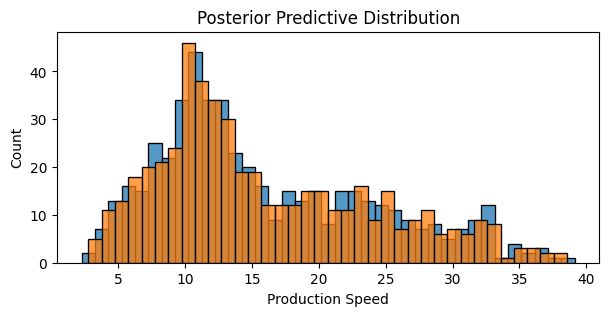

In [246]:
simulated_dataset["preds"] = pps["obs"].mean(axis=0)

plt.figure(figsize=(7, 3))
sns.histplot(data=simulated_dataset, x="Production_Speed", binwidth=1, label="obs")
sns.histplot(data=simulated_dataset, x="preds", binwidth=1, label="pps")
plt.xlabel("Production Speed")
plt.title("Posterior Predictive Distribution");

This plot compares the observed production speeds with the model's predictions, allowing us to assess how well our model captures the underlying patterns in the data.

In [250]:
config_idx_new = jnp.array([0, 1], dtype=jnp.int32)

X_test = jnp.array([
    [3.0, 2.0, 0.0],
    [3.0, 2.0, 2.0]
])

rng_key, rng_subkey = random.split(key=rng_key)
pps_new = predictive(
    rng_subkey,
    parameter_mask,
    config_idx_new,
    X_test,
    None
)

pps_new["obs"].mean(axis=0)

Array([13.455311, 10.143251], dtype=float32)

In [253]:
config_idx_new = jnp.array([0, 1], dtype=jnp.int32)

X_test = jnp.array([
    [6.0, 2.0, 2.0],
    [6.0, 2.0, 2.0]
])

rng_key, rng_subkey = random.split(key=rng_key)
pps_new = predictive(
    rng_subkey,
    parameter_mask,
    config_idx_new,
    X_test,
    None
)

pps_new["obs"].mean(axis=0)

Array([20.98238 , 13.135274], dtype=float32)

## Conclusion

Hierarchical regression, combined with parameter masking, provides a powerful framework for analyzing grouped data with missing values. This approach allows us to:

1. Account for group-specific variations in the relationships between predictors and outcomes.
2. Handle missing data without requiring imputation or discarding incomplete cases.
3. Make predictions for new data, even when some predictors are not applicable to certain groups.

In real-world applications, such as manufacturing process modeling, this methodology enables more accurate modeling and prediction, leading to better decision-making and process improvements. By effectively leveraging all available data, including partial information from groups with missing predictors, we can gain deeper insights into complex processes.